[0]	eval-rmse:11.54013
[100]	eval-rmse:11.37600
[200]	eval-rmse:11.22872
[300]	eval-rmse:11.08707
[400]	eval-rmse:10.95536
[500]	eval-rmse:10.83331
[600]	eval-rmse:10.70984
[700]	eval-rmse:10.59078
[800]	eval-rmse:10.47850
[900]	eval-rmse:10.36900
[1000]	eval-rmse:10.26345
[1100]	eval-rmse:10.16358
[1200]	eval-rmse:10.06509
[1300]	eval-rmse:9.96442
[1400]	eval-rmse:9.86547
[1500]	eval-rmse:9.77963
[1600]	eval-rmse:9.68816
[1700]	eval-rmse:9.60396
[1800]	eval-rmse:9.51734
[1900]	eval-rmse:9.43394
[2000]	eval-rmse:9.35260
[2100]	eval-rmse:9.26732
[2200]	eval-rmse:9.19197
[2300]	eval-rmse:9.11460
[2400]	eval-rmse:9.03931
[2500]	eval-rmse:8.96478
[2600]	eval-rmse:8.88905
[2700]	eval-rmse:8.81837
[2800]	eval-rmse:8.74159
[2900]	eval-rmse:8.67030
[3000]	eval-rmse:8.59997
[3100]	eval-rmse:8.53257
[3200]	eval-rmse:8.46527
[3300]	eval-rmse:8.39797
[3400]	eval-rmse:8.33167
[3500]	eval-rmse:8.26947
[3600]	eval-rmse:8.20908
[3700]	eval-rmse:8.14377
[3800]	eval-rmse:8.08113
[3900]	eval-rmse:8.02049

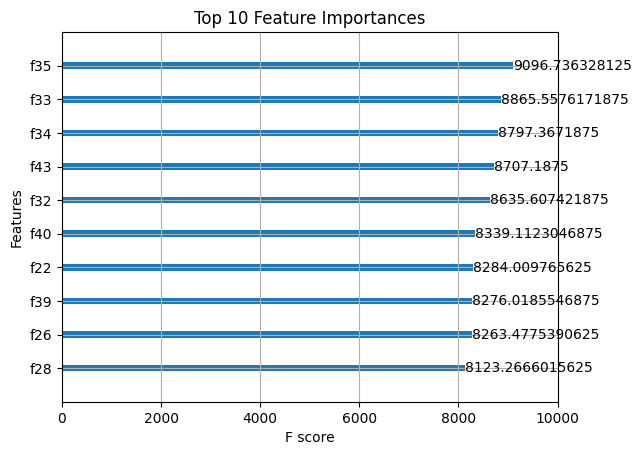

In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# STEP 1: Load training data
train_df = pd.read_csv("/kaggle/input/test-sample/train.csv")

# STEP 2: Encode categorical columns in train
label_encoders = {}
for col in train_df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col].astype(str))
    label_encoders[col] = le  # Save encoder for test

# STEP 3: Define target and features
target_column = 'Lap_Time_Seconds'
X = train_df.drop(columns=[target_column])
y = train_df[target_column]

# STEP 4: Train-test split for validation
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# STEP 5: Scale input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

# STEP 6: DMatrix conversion
dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
dvalid = xgb.DMatrix(X_valid_scaled, label=y_valid)

# STEP 7: Model parameters
params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.05,
    'max_depth': 5,
    'min_child_weight': 1,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'reg_alpha': 1,
    'reg_lambda': 2,
    'nthread': -1,
    'seed': 42
}

# STEP 8: Train model
model = xgb.train(
    params,
    dtrain,
    num_boost_round=5000,
    evals=[(dvalid, 'eval')],
    early_stopping_rounds=200,
    verbose_eval=100
)

# STEP 9: Evaluate RMSE on validation set
y_pred_valid = model.predict(dvalid)
rmse = np.sqrt(mean_squared_error(y_valid, y_pred_valid))
print(f"✅ Validation RMSE: {rmse:.5f} seconds")

# STEP 10: Load test data
test_df = pd.read_csv("/kaggle/input/test-sample/test.csv")

# STEP 11: Apply the same label encodings to test data
for col in test_df.select_dtypes(include='object').columns:
    if col in label_encoders:
        test_df[col] = label_encoders[col].transform(test_df[col].astype(str))

# STEP 12: Scale test features
X_test_scaled = scaler.transform(test_df)

# STEP 13: Predict on test data
dtest_final = xgb.DMatrix(X_test_scaled)
y_test_pred = model.predict(dtest_final)

# STEP 14: Save predictions
submission = pd.DataFrame({
    "Unique ID": test_df["Unique ID"],
    "Predicted_Lap_Time_Seconds": y_test_pred
})
submission.to_csv("solution.csv", index=False)
print("📁 solution.csv with test predictions has been saved.")

# STEP 15: Feature importance (optional)
xgb.plot_importance(model, max_num_features=10, importance_type='gain')
plt.title("Top 10 Feature Importances")
plt.show()